# Building a bigram model

*This is the start of episode 2... building makemore.*  The main point of this is to introduce the basic building blocks by using bigrams. This notebook covered:
- Counting bigram frequencies with Python and PyTorch
- Representing bigrams using tensors
- Sampling from a bigram distribution using `torch.multinomial`
- Building a tiny neural network to learn bigram probabilities
- Training using gradient descent and negative log likelihood loss
- Compare results from both approaches.

This serves as a foundation for future notebooks where we continue the makemore series [makemore series](https://youtu.be/TCH_1BHY58I?si=8cnnMb7Rvynpk_sz)

## Load Data

In [25]:
file = open('names.txt')
names = file.read().strip().split()

## Counting Bigrams

In [1027]:
# Naively, we can count bigram occurances in our names using a dictionary
# First, we gather the relevent characters then loop over all names and 
chars = sorted(set(list(''.join(names))))

bigrams = {}
for name in names:
    name = '.' + name + '.'
    for c1, c2 in zip(name, name[1:]):
        if (c1, c2) in bigrams:
            bigrams[(c1, c2)] += 1
        else:
            bigrams[(c1, c2)] = 1

### Sanity check
*Just want to verify that we get the same occurances as Andrej*

In [1029]:
# Let's order by the most frequent bigrams
sort_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)
# Sanity check
sort_bigrams[:10]

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963)]

### Create char $\rightarrow$ int and int $\rightarrow$ char mappings

In [934]:
# Maps character to index
stoi = {}
i = 1
for char in chars:
    stoi[str(char)] = i
    i += 1
stoi['.'] = 0

In [936]:
# Maps index to character
itos = {}
for char in stoi:
    i = stoi[char]
    itos[i] = char

In [940]:
# Run to verify that the composition gives the identity map (should print char char)
for char in stoi:
    print(char, itos[stoi[char]])

a a
b b
c c
d d
e e
f f
g g
h h
i i
j j
k k
l l
m m
n n
o o
p p
q q
r r
s s
t t
u u
v v
w w
x x
y y
z z
. .


## Building the Bigram Matrix
- We will create a tensor that stores the number of times a bigram appears
- The i,j entry of the tensor will give an integer value that represents the number of times that the jth character in the alphabet follows the ith character of the alphabet
- EX: N[2,3] will be the total number of times that 'bc' occurs in the list of bigrams

In [942]:
import torch

N = torch.zeros((27,27), dtype=torch.int32)
     
for name in names:
    chars = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        N[ix1, ix2] += 1    

In [944]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

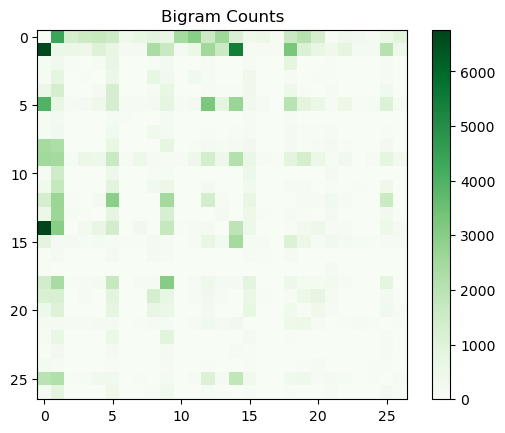

In [1117]:
import matplotlib.pyplot as plt
plt.imshow(N, cmap='Greens')
plt.title("Bigram Counts")
plt.colorbar();

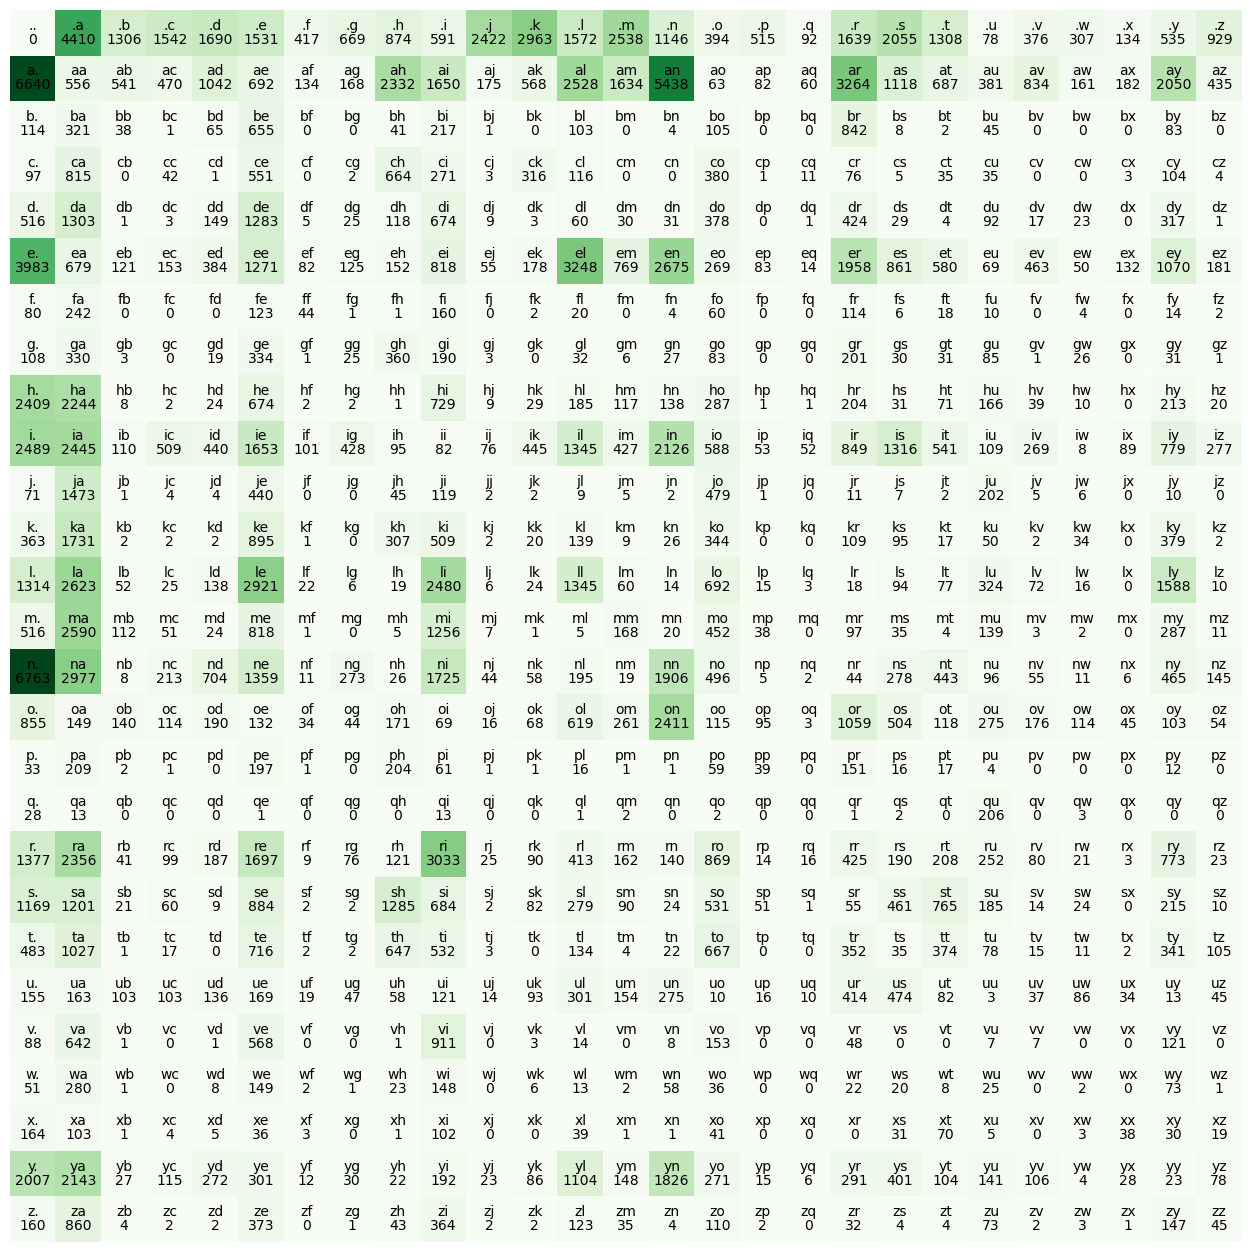

In [948]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=[16,16])
plt.imshow(N, cmap='Greens') #I like green
for i in range(27):
    for j in range(27):
        bigram = itos[i] + itos[j]
        plt.text(j,i, bigram, ha="center", va="bottom")
        plt.text(j,i, N[i,j].item(), ha="center", va="top")
plt.axis('off');

In [950]:
p = N[0].float()
p = p/p.sum()
print(p)

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])


### Sampling from the bigram model
- Okay... blaming this on versioning? Basically, we get different results to Andrej but have double checked the code multiple times and it seems okay. 
- Basically, from the first row of the bigrams tensor (with num_samples=1) I get an index of 10 rather than 13, so our name starts with 'j' rather than 'm'.


In [1043]:
g = torch.Generator().manual_seed(2147483647)
p = N[0]
p = p/p.sum()
for _ in range(7):
    x1 = torch.multinomial(p, num_samples=1, replacement=True, generator=g)
    print(x1.item())
    p = N[x1.item()]
    p = p/p.sum()

10
21
14
9
4
5
0


In [954]:
# Probability matrix (broadcasting rules!)
# Add 1 to each entry of N so you don't run into issues trying to plug 0 into log! i.e. avoid nll = 'inf'
P = (N+1).float()
P /= P.sum(1,keepdims=True)

In [956]:
P

tensor([[3.1192e-05, 1.3759e-01, 4.0767e-02, 4.8129e-02, 5.2745e-02, 4.7785e-02,
         1.3038e-02, 2.0898e-02, 2.7293e-02, 1.8465e-02, 7.5577e-02, 9.2452e-02,
         4.9064e-02, 7.9195e-02, 3.5777e-02, 1.2321e-02, 1.6095e-02, 2.9008e-03,
         5.1154e-02, 6.4130e-02, 4.0830e-02, 2.4641e-03, 1.1759e-02, 9.6070e-03,
         4.2109e-03, 1.6719e-02, 2.9008e-02],
        [1.9583e-01, 1.6425e-02, 1.5983e-02, 1.3889e-02, 3.0756e-02, 2.0435e-02,
         3.9809e-03, 4.9835e-03, 6.8796e-02, 4.8685e-02, 5.1899e-03, 1.6779e-02,
         7.4575e-02, 4.8213e-02, 1.6039e-01, 1.8872e-03, 2.4475e-03, 1.7988e-03,
         9.6279e-02, 3.2997e-02, 2.0288e-02, 1.1264e-02, 2.4623e-02, 4.7771e-03,
         5.3963e-03, 6.0480e-02, 1.2857e-02],
        [4.3039e-02, 1.2051e-01, 1.4596e-02, 7.4850e-04, 2.4701e-02, 2.4551e-01,
         3.7425e-04, 3.7425e-04, 1.5719e-02, 8.1587e-02, 7.4850e-04, 3.7425e-04,
         3.8922e-02, 3.7425e-04, 1.8713e-03, 3.9671e-02, 3.7425e-04, 3.7425e-04,
         3.1549e-

### Sample from the bigram model
- Let's generate some 'names'.

In [958]:
 g = torch.Generator().manual_seed(2147483647)

for _ in range(5):
    samples = []
    ix = 0
    while True:
        p = P[ix]
        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        if ix == 0:
            break
        samples.append((itos[ix]))
    print(''.join(samples))

junide
janasah
p
cony
a


In [960]:
log_likelihood = 0.0
n = 0
for name in names:
    chs = ['.'] + list(name) + ['.']
    for c1, c2 in zip(chs, chs[1:]):
        x1 = stoi[c1]
        x2 = stoi[c2]
        prob = P[x1, x2]
        logprob = torch.log(prob)
        log_likelihood += logprob
        n += 1
        #print(f"{c1}{c2} = {prob:.4f}, logprob={logprob:.4f}")
print(f'{log_likelihood=}')
nll = - log_likelihood
print(f'{nll=}')
print(f'{nll/n}')

log_likelihood=tensor(-559951.5625)
nll=tensor(559951.5625)
2.4543561935424805


## Building the bigram matrix via a Neural Network

In [1100]:
# NOW for the Neural Network!
import torch.nn.functional as F

xs, ys = [], []


for name in names[:1]:
    chars = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        print(ch1, ch2)
        xs.append(ix1)
        ys.append(ix2) 
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [1102]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g)

In [1104]:
xenc = F.one_hot(xs, num_classes=27).float() # input to the network
logits = xenc @ W # predict log-counts

# SOFTMAX
counts = logits.exp() # counts, should be equivalent to our array N above
probs = counts/counts.sum(1, keepdims=True) # probabilities for the next character

In [1106]:
probs.shape

torch.Size([5, 27])

### understanding negative log likelihood 

In [974]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram
    x = xs[i].item()
    y = ys[i].item()
    print('----')
    print(f'bigram example {i+1}: {itos[x]}{itos[y]}')
    print('input to the neural net:', x)
    print('output probs from the neural net:', probs[i])
    print('label (actual next character):', y)
    p = probs[i,y]
    print('probability assigned by the net for the next character:', p.item())
    logp = torch.log(p)
    print(f'log likelihood: {logp.item()}')
    nll = -logp
    print(f'negative log likelihood: {nll.item()}')
    nlls[i] = nll

print('======')
print('average negative log likelihood, i.e. loss=', nlls.mean().item())
    

----
bigram example 1: .e
input to the neural net: 0
output probs from the neural net: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the net for the next character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
----
bigram example 2: em
input to the neural net: 5
output probs from the neural net: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the net for the next character: 0.018050700426101685
log likelihood: -4.014570713043213
negative lo

### towards optimization

In [1122]:
xs

tensor([ 0,  5, 13, 13,  1])

In [979]:
ys

tensor([ 5, 13, 13,  1,  0])

In [981]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

In [983]:
# forward pass
xenc = F.one_hot(xs, num_classes=27).float()
logits = xenc @ W
counts = logits.exp()
probs = counts/counts.sum(1, keepdims=True)
loss = -probs[torch.arange(5), ys].log().mean()

In [985]:
loss.item()

3.7693049907684326

In [987]:
# backward pass
W.grad = None
loss.backward()

In [989]:
W.data -= 0.1*W.grad

## Optimization Loop

In [991]:
xs = []
ys = []
for name in names:
    chars = ['.'] + list(name) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2) 
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

print('number of examples =', num)

g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27,27), generator=g, requires_grad=True)

number of examples = 228146


In [1007]:
# gradient descent
for _ in range(100):
    #forward pass
    xenc = F.one_hot(xs, num_classes=27).float()
    logits = xenc @ W
    logits_exp = logits.exp()
    probs = logits_exp / logits_exp.sum(1, keepdims=True)
    loss = -probs[torch.arange(num), ys].log().mean()  # + 0.01*(W**2).mean()

    # backward pass
    W.grad = None
    loss.backward()

    # update
    W.data += -50*W.grad

## Sampling from the neural bigram model

In [1015]:
g = torch.Generator().manual_seed(2147483647)


for i in range(5):
    out = []
    ix = 0
    while True:

        #p = P[ix]
        
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W
        exp_logits = logits.exp()
        p = exp_logits/exp_logits.sum(1, keepdims=True)

        ix = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itos[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
prelay.
a.
nn.


## Reflections and Next Steps

. A few things to note:

- it seems that `torch.multinomial` gives us a different result than Andrej
- this episode was great: it built very simply and naturally from basic counting/statistics and sampling from probability distributions using torch.multinomial, to a fully trainable neural net

### What's next?
A trigram model?
